# 2025 CITS4012 Individual Assignment

# Readme
Before running the notebook, ensure the relevant files are saved in your Google Drive (if running in Colab) with the naming conventions as follows:

Parent directory: 'MyDrive/files/' (this can be changed in section 1)

*   medical_tc_train.csv
*   medical_tc_test.csv
*   medical_tc_labels.csv
*   bio_embedding_extrinsic


If running locally and not mounting to a Google Drive, delete the relevant cell in section 1.


In [2]:
%pip install spacy
%pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz
%pip install scispacy
%pip install gensim
%pip install matplotlib
%pip install tensorflow
%pip install ipywidgets

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz (14.8 MB)
  Preparing metadata (setup.py) ... done


In [3]:
import spacy
import scispacy
import csv
import gensim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN, Masking
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score
import ipywidgets as widgets
from IPython.display import display, clear_output
from tensorflow.keras.layers import Bidirectional

# 1.Dataset Processing

In [4]:
# If extracting files from local directory: delete this section
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Change this if needed
directory = "/content/drive/MyDrive/files/"

In [6]:
def read_data(fname):
    X = []
    y = []
    with open(fname, newline='\n') as csvfile:
        reader = csv.reader(csvfile, delimiter=",")
        next(reader) # skips first row (headers)
        for row in reader:
            X.append(row[1])
            y.append(int(row[0]))

    return X, y

train_X_raw, train_y = read_data(directory + "medical_tc_train.csv")
test_X_raw, test_y = read_data(directory + "medical_tc_test.csv")
labels, _ = read_data(directory + "medical_tc_labels.csv")

#labels contains a list of labels, where labels[i] corresponds to value i in train_y or test_y sets

In [7]:
biomedical_nlp = spacy.load("en_core_sci_sm") #imports a biomedical scispaCy NLP model
def preprocess(X):
    preprocessed_X = []
    for p in biomedical_nlp.pipe(X, batch_size=32, n_process=4): #pipe is far faster than manual loop
        tokens=[
            token.lemma_.lower() #lemmatization, #case insensitivity
            for token in p
            if not token.is_stop and not token.is_punct #removal of stopwords and punctuation so things like '%' are not counted as tokens
        ]
        preprocessed_X.append(tokens)
    return preprocessed_X

train_X = preprocess(train_X_raw)
test_X = preprocess(test_X_raw)


/usr/local/lib/python3.11/dist-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [8]:
n_classes = max(test_y + train_y)

train_y_1hot = to_categorical(np.array(train_y) - 1, num_classes=n_classes)
test_y_1hot = to_categorical(np.array(train_y) - 1, num_classes=n_classes)

# 2.Word Embedding Construction
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [9]:
word2vec = gensim.models.Word2Vec(train_X, min_count=5) #default was 5

In [10]:
bio_wordvec_file = directory + "bio_embedding_extrinsic"
bio_wordvec = gensim.models.KeyedVectors.load_word2vec_format(bio_wordvec_file, binary=True)

bio_wordvec_vectors= {}
for X_i in train_X:
    for token in X_i:
        if token in bio_wordvec.key_to_index:
            bio_wordvec_vectors[token] = bio_wordvec[token]

# 3.Visualization

In [11]:
def min_max_x_y(word2vec_transformed, biowordvec_transformed, buffer):
    all_points = np.vstack([word2vec_transformed, biowordvec_transformed])
    xmin, ymin = all_points.min(axis=0)
    xmax, ymax = all_points.max(axis=0)

    x_range = xmax - xmin
    y_range = ymax - ymin

    # Add [buffer]% gap on each side for aesthetic reasons only
    buffer_x = x_range * buffer
    buffer_y = y_range * buffer

    xmin = xmin - buffer_x
    xmax = xmax + buffer_x
    ymin = ymin - buffer_y
    ymax = ymax + buffer_y

    return xmin, xmax, ymin, ymax


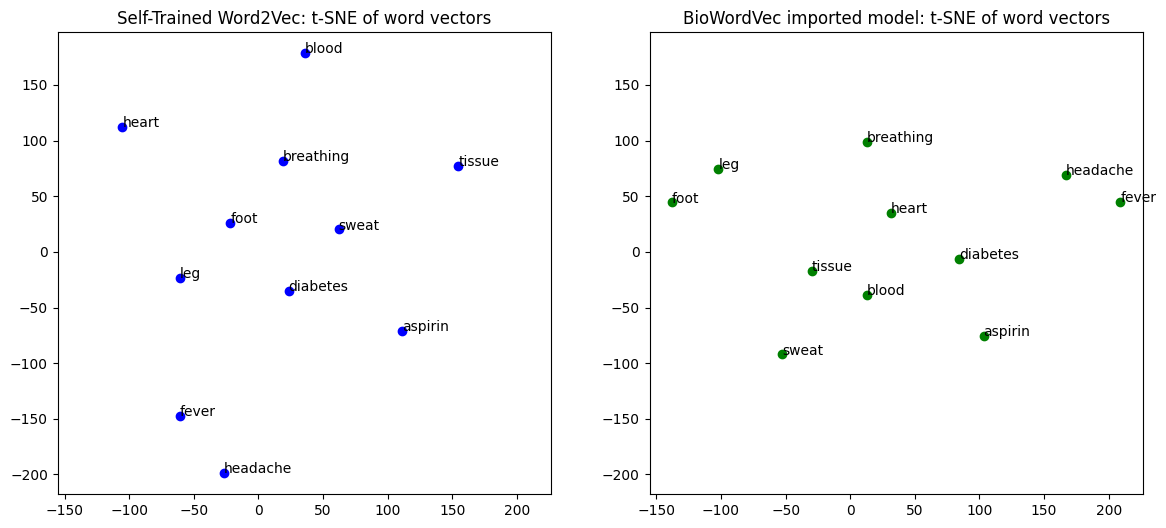

In [12]:
visualised_words = ["aspirin", "diabetes", "tissue", "blood", "heart", "breathing", "sweat", "headache", "fever", "leg", "foot"]

bio_wordvec_visualised_vecs = []
word2vec_visualised_vecs = []

for word in visualised_words:

    bio_wordvec_visualised_vecs.append(bio_wordvec[word])
    word2vec_visualised_vecs.append(word2vec.wv[word])

bio_wordvec_visualised_vecs = np.array(bio_wordvec_visualised_vecs)
word2vec_visualised_vecs = np.array(word2vec_visualised_vecs)

word2vec_transformed = TSNE(n_components=2, perplexity=5).fit_transform(word2vec_visualised_vecs)
biowordvec_transformed = TSNE(n_components=2, perplexity=5).fit_transform(bio_wordvec_visualised_vecs)

# These ensure both scales are the same
xmin, xmax, ymin, ymax = min_max_x_y(word2vec_transformed, biowordvec_transformed, 0.05)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(word2vec_transformed[:,0], word2vec_transformed[:,1], color='blue')

for i, word in enumerate(visualised_words):
    axes[0].annotate(word, (word2vec_transformed[i,0], word2vec_transformed[i,1]))
axes[0].set_title("Self-Trained Word2Vec: t-SNE of word vectors")
axes[0].set_xlim(xmin, xmax)
axes[0].set_ylim(ymin, ymax)

axes[1].scatter(biowordvec_transformed[:,0], biowordvec_transformed[:,1], color='green')

for i, word in enumerate(visualised_words):
    axes[1].annotate(word, (biowordvec_transformed[i,0], biowordvec_transformed[i,1]))
axes[1].set_title("BioWordVec imported model: t-SNE of word vectors")
axes[1].set_xlim(xmin, xmax)
axes[1].set_ylim(ymin, ymax)

plt.show()

# 3.2 Interpretation

The clearest takeaway from comparing the two t-SNE dimensionality-reduced plots of the self-trained Word2Vec model and the imported BioWordVec model is the marked difference in the projections of their word vectors. There is almost no correlation between the locations of vectors in the Word2Vec and BioWordVec projections. This result is unsurprising, as these models use entirely different training algorithms and likely different hyperparameters. Notably, the models also differ in vector dimensionality: the Word2Vec implementation uses 100-dimensional vectors, while BioWordVec uses 200-dimensional vectors. Finally, the Word2Vec embeddings are trained on the corpus of abstracts in the training set, whereas BioWordVec simply extracts vectors for occurring words from a pre-existing embedding dataset.

Although the positions of vectors differ, some spatial relationships between embeddings show similarities. For example, pairs like 'headache' & 'fever' or 'foot' & 'leg' are close to each other in both embeddings, reflecting a low magnitude of difference between these vectors. These words are likely to appear in similar contexts and have closely related semantic meanings, which explains why they are represented by similar vectors.

While the two embedding models project words to different and seemingly unrelated positions, the relative distances between semantically related words are preserved. This suggests that both models capture similar relationships between embeddings of related meanings, despite differences in training and dimensionality.

# 4.RNN-based Model Implementation

In [21]:
#Pre-processing for RNN

max_tokens = max(len(X_i) for X_i in (train_X + test_X))

train_X_padded_w2v = np.zeros((len(train_X), max_tokens, 100))
train_X_padded_biovec = np.zeros((len(train_X), max_tokens, 200))
test_X_padded_w2v = np.zeros((len(test_X), max_tokens, 100))
test_X_padded_biovec = np.zeros((len(test_X), max_tokens, 200))



for i, paragraph in enumerate(train_X):
    for j, token in enumerate(paragraph):

        if token in word2vec.wv.key_to_index:
            train_X_padded_w2v[i, j, :] = word2vec.wv[token]

        if token in bio_wordvec.key_to_index:
            train_X_padded_biovec[i, j, :] = bio_wordvec[token]


for i, paragraph in enumerate(test_X):
    for j, token in enumerate(paragraph):

        if token in word2vec.wv.key_to_index:
            test_X_padded_w2v[i, j, :] = word2vec.wv[token]

        if token in bio_wordvec.key_to_index:
            test_X_padded_biovec[i, j, :] = bio_wordvec[token]


In [31]:
def build_rnn_model(max_tokens, embedding_dim, num_classes):
    model = Sequential()
    model.add(Masking(mask_value=0.0, input_shape=(max_tokens, embedding_dim))) # use this line to ignore all 0.0 (padded) values that were added.
    model.add(LSTM(128, use_cudnn=False))
    model.add(Dropout(0.5)) # Reduce overfitting
    model.add(Dense(num_classes, activation='softmax')) # Class probability predictions
    return model

In [37]:
model_w2v = build_rnn_model(max_tokens, 100, n_classes)
model_biowordvec = build_rnn_model(max_tokens, 200, n_classes)

#Adam: converges faster, handles sparse gradients
# CCE
model_w2v.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_biowordvec.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_w2v = model_w2v.fit(train_X_padded_w2v, train_y_1hot, batch_size=32, epochs=10, validation_split=0.2)
history_biowordvec = model_biowordvec.fit(train_X_padded_biovec, train_y_1hot, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.4439 - loss: 1.2994 - val_accuracy: 0.5299 - val_loss: 1.1286
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.5455 - loss: 1.1072 - val_accuracy: 0.5394 - val_loss: 1.1365
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.5705 - loss: 1.0522 - val_accuracy: 0.5221 - val_loss: 1.1270
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.5897 - loss: 1.0187 - val_accuracy: 0.5550 - val_loss: 1.0365
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.5997 - loss: 0.9777 - val_accuracy: 0.5797 - val_loss: 1.0113
Epoch 6/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.6178 - loss: 0.9393 - val_accuracy: 0.5805 - val_loss: 1.0037
Epoch 7/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.6205 - loss: 0.9242 - val_accuracy: 0.5693 - val_loss: 1.0063
Epoch 8/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.6255 - loss: 0.8982 - 

# 5.Performance Evaluation

In [40]:
prob_w2v = model_w2v.predict(test_X_padded_w2v)
prob_biovec = model_biowordvec.predict(test_X_padded_biovec)

preds_w2v = np.argmax(prob_w2v, axis=1) + 1
preds_biovec = np.argmax(prob_biovec, axis=1) + 1

91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


In [41]:
acc_w2v = np.mean(preds_w2v == test_y)
acc_biovec = np.mean(preds_biovec == test_y)

print("Word2Vec Model accuracy: ", acc_w2v)
print("BioWordVec Model accuracy: ", acc_biovec)

f1_w2v = f1_score(test_y, preds_w2v, average='macro')  # or 'weighted', 'micro'
f1_biovec = f1_score(test_y, preds_biovec, average='macro')  # or 'weighted', 'micro'

print("Word2Vec F1 score: ", f1_w2v)
print("BioWordVec F1 score: ", f1_biovec)

Word2Vec Model accuracy:  0.5893351800554016
BioWordVec Model accuracy:  0.6381578947368421
Word2Vec F1 score:  0.5737265722129734
BioWordVec F1 score:  0.6399617671561867


The results show that the imported BioWordVec model outperforms the self-trained Word2Vec model. BioWordVec achieves an accuracy of 59% compared to Word2Vec’s 63%, and an F1 score of 57% versus 64% for Word2Vec. This suggests that using pre-trained embeddings from BioWordVec provides better generalization on this task, likely because it was trained on a larger corpus, capturing richer semantic relationships than the smaller self-trained Word2Vec embeddings. The difference in F1 score, which accounts for both precision and recall, indicates that BioWordVec is better at correctly identifying positive instances while simultaneously minimising false positives and false negatives. This is particularly important in NLP tasks with imbalanced classes or when the accurate diagnoses of medical abstracts is critical, and can even determine patient long term health or survival.

These are likely relatively low due to the complexity of the classification tasks. Each instance contains nuanced and extensive deatils about a patient, with relevance of each token being difficult to encode and train. Instances also feature significant overlap of tokens. The model's ability to learn may have also been impacted by imperfections in the training data, such as inconsistent terminology and abbreviation/acronym usage. The models also had almost no ability to comprehend quantitative data, such as blood pressure levels, heartrates, temperatures, etc. as numbers and symbols are not properly tokenised. A more accurate model would better parse these to obtain a deeper understanding. Finally, this model was restricted by time and computing capacities, with more larger models and longer training possibly leading to less underfitting and higher test accuracies.

# 6.Interactive Inference Colab Form

In [38]:
def predictor(method, abstract_index):
    if method == "word2vec":

        probs = model_w2v.predict([test_X_padded_w2v[abstract_index:abstract_index+1]]) #indexed like this to keep it 3d np array

    elif method == "biowordvec":
        probs = model_biowordvec.predict([test_X_padded_biovec[abstract_index:abstract_index+1]]) #indexed like this to keep it 3d np array

    y_pred = np.argmax(probs, axis=1) + 1

    return y_pred

In [39]:
# Initial values
model = "word2vec"
index = 0

# Create buttons
w2v_button = widgets.Button(description="Use Word2Vec trained model", layout=widgets.Layout(width='25%', height='15%'), button_style = "primary") #initially set it to the one selected
biovec_button = widgets.Button(description="Use pre-trained BioWordVec model", layout=widgets.Layout(width='25%', height='15%'))
submit_button = widgets.Button(
    description="Submit",
    layout=widgets.Layout(width="150px", height="50px", margin="20px 0px 20px 0px"),  # bigger size
    style={'button_color': 'lightgray'}  # grey background
)

# Define what happens when buttons are clicked
def w2v_button_click(b):
    global model
    model = "word2vec"
    w2v_button.button_style = "primary"
    biovec_button.button_style = ""   # reset other

def biovec_button_click(b):
    global model
    model = "biowordvec"
    biovec_button.button_style = "primary"
    w2v_button.button_style = ""

def submit_click(b):
    #make the class prediction based on the chosen model and abstract index
    y_pred = predictor(model, index)[0]
    #If correct, make pred descriptor green. Else red
    color = "green" if y_pred == test_y[index] else "red"

    clear_output(wait=False)

    predict_label = widgets.HTML(f"<b style='color: {color}'"">Predicted Diagnosis:</b>")
    actual_label  = widgets.HTML("<b>Actual Diagnosis:</b>")

    actual_class_text = widgets.Text(
        value=f'{labels[test_y[index]-1]}',
        layout=widgets.Layout(width='35%', margin='0% 3% 0% 1%'),

    )

    predict_class_text = widgets.Text(
        value=f'{labels[y_pred-1]}',
        layout=widgets.Layout(width='35%', margin='0% 0% 0% 1%')
    )

    #Re-display everything, including the ground truth and predicted classes
    display(widgets.VBox([widgets.HBox([w2v_button, biovec_button]),dropdown, output, submit_button, widgets.HBox([actual_label, actual_class_text, predict_label, predict_class_text])]))

#Event listeners for button clicks
w2v_button.on_click(w2v_button_click)
biovec_button.on_click(biovec_button_click)
submit_button.on_click(submit_click)


#Create dropdown list for abstract selection
test_indices = range(len(test_X_raw))
dropdown = widgets.Dropdown(
    options=[(f"Abstract {i+1}", i) for i in test_indices],
    layout=widgets.Layout(width="20%")
)

# Scrollable, wrapped text box
# Initialise to displaying first abstract
output = widgets.HTML(
    value=f"<div style='white-space: normal; word-wrap: break-word;'>{test_X_raw[index]}</div>",
    layout=widgets.Layout(
        border='1px solid gray',
        width='95%',
        height='300px',
        overflow_y='auto',
        padding='10px',
        word_wrap='break-word'  #  wrapping
    )
)

# Function to update the abstract display
def show_abstract(change):
    global index
    index = change.new  # the selected index from the dropdown
    output.value = f"<div style='white-space: normal; word-wrap: break-word;'>{test_X_raw[index]}</div>" #change value of text box

#When different options on drop down selected, show_abstract called with chosen index passed through
dropdown.observe(show_abstract, names='value')

display(widgets.VBox([widgets.HBox([w2v_button, biovec_button]), dropdown, output, submit_button]))
